In [1]:
%load_ext autoreload%autoreload 2import osfrom dotenv import load_dotenv# 加载环境变量文件load_dotenv()# 检查环境变量中是否包含 OPENAI_API_KEYassert 'OPENAI_API_KEY' in os.environ

In [2]:
# 导入dspy模块import dspy# 使用OpenAI函数创建一个名为turbo的模型，模型为'gpt-3.5-turbo'，最大token数为4000turbo = dspy.OpenAI(model='gpt-3.5-turbo', max_tokens=4000)# 使用OpenAI函数创建一个名为gpt4的模型，模型为'gpt-4'，最大token数为4000gpt4 = dspy.OpenAI(model='gpt-4', max_tokens=4000)# 配置dspy的设置，将语言模型设置为turbodspy.settings.configure(lm=turbo)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import dspy# 创建一个TypedPredictor对象，指定输入为"question"，输出为"answer"predictor = dspy.TypedPredictor("question -> answer")# 使用predictor对问题"What is the capital of France?"进行预测prediction = predictor(question="What is the capital of France?")

Prediction(
    answer='Paris'
)

In [4]:
from dspy.datasets import HotPotQA# 加载数据集dataset = HotPotQA(train_seed=1, train_size=20, eval_seed=2023, dev_size=50, test_size=0)# 告诉DSPy 'question' 字段是输入。其他字段是标签和/或元数据。trainset = [x.with_inputs('question') for x in dataset.train]devset = [x.with_inputs('question') for x in dataset.dev]len(trainset), len(devset)

(20, 50)

In [5]:
# 导入 Evaluate 类from dspy.evaluate import Evaluate# 导入 answer_exact_match 函数from dspy.evaluate.metrics import answer_exact_match# 导入 TypedPredictor 和 TypedChainOfThought 类from dspy.functional import TypedPredictor, TypedChainOfThought# 导入 optimize_signature 函数from dspy.teleprompt.signature_opt_typed import optimize_signature# 创建 Evaluate 实例，传入参数 devset, metric, num_threads, display_progressevaluator = Evaluate(devset=devset, metric=answer_exact_match, num_threads=10, display_progress=True)

In [6]:
# 调用 optimize_signature 函数，传入参数result = optimize_signature(    # 定义学生模型，使用 TypedChainOfThought 类，模型结构为 "question -> answer"    student=TypedChainOfThought("question -> answer"),    # 传入评估器 evaluator    evaluator=evaluator,    # 初始提示数量为 6    initial_prompts=6,    # 迭代次数为 100    n_iterations=100,    # 最大示例数量为 30    max_examples=30,    # 打印详细信息    verbose=True,    # 使用 gpt4 作为提示模型    prompt_model=gpt4,)

检查优化后的最终程序

In [ ]:
# 导入result模块中的program函数from result import program# 调用program函数并将结果存储在result变量中result = program()

绘制随时间变化的分数

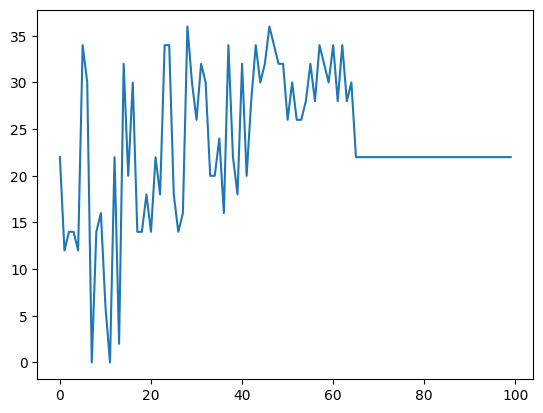

In [ ]:
import matplotlib.pyplot as plt  # 导入matplotlib.pyplot模块plt.plot(result.scores)  # 绘制result.scores的折线图

In [ ]:
# 使用GPT-4模型的inspect_history方法查看模型训练历史记录gpt4.inspect_history(n=1)





You are an instruction optimizer for large language models.

I will give some task instructions I've tried, along with their corresponding validation scores.
- The instructions are arranged in order based on their scores, where higher scores indicate better quality.
- Your task is to propose a new instruction that will lead a good language model to perform the task even better.
- Be creative, and think out of the box.
- Don't repeat instructions, descriptions and prefixes that have already been attempted.

---

Follow the following format.

Analysis: Consider what made the previous instructions good or bad.
Proposed Signature: A signature that will likely lead to a high score.. Respond with a single JSON object. JSON Schema: {"properties": {"instructions": {"description": "The instructions for the task", "title": "Instructions", "type": "string"}, "question_prefix": {"description": "The prefix for question", "title": "Question Prefix", "type": "string"}, "question_desc": {"descript

# 多跳让我们尝试一个多跳的例子

In [8]:
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')dspy.settings.configure(rm=colbertv2_wiki17_abstracts)class GenerateSearchQuery(dspy.Signature):    """编写一个简单的搜索查询，以帮助回答复杂问题。"""    context:list[str] = dspy.InputField(desc="可能包含相关事实")    question = dspy.InputField()    query = dspy.OutputField()class GenerateAnswer(dspy.Signature):    """用简短的事实性答案回答问题。"""    context:list[str] = dspy.InputField(desc="可能包含相关事实")    question = dspy.InputField()    answer = dspy.OutputField(desc="通常在1到5个词之间")from dsp.utils import deduplicateclass SimplifiedBaleen(dspy.Module):    def __init__(self, passages_per_hop=3, max_hops=2):        super().__init__()        self.generate_query = [dspy.TypedChainOfThought(GenerateSearchQuery) for _ in range(max_hops)]        self.retrieve = dspy.Retrieve(k=passages_per_hop)        self.generate_answer = dspy.TypedChainOfThought(GenerateAnswer)        self.max_hops = max_hops        def forward(self, question):        context = []                for hop in range(self.max_hops):            query = self.generate_query[hop](context=context, question=question).query            passages = self.retrieve(query).passages            context = deduplicate(context + passages)        pred = self.generate_answer(context=context, question=question)        return dspy.Prediction(context=context, answer=pred.answer)

In [9]:
from simplified_scrapy import SimplifiedDoc, SimplifiedBaleen# 创建一个 SimplifiedBaleen 对象baleen = SimplifiedBaleen()# 使用 baleen 对象提问问题 "What is the capital of France?"baleen(question="法国的首都是哪里？")

Prediction(
    context=['Paris (disambiguation) | Paris is the largest city and capital of France.', 'Capital (French magazine) | Capital is a monthly French economics and business magazine published in Paris, France.', 'Paris | Paris (] ) is the capital and most populous city of France, with an administrative-limits area of 105 km2 and a 2015 population of 2,229,621. The city is a commune and department, and the capital-heart of the 12,012 km2 Île-de-France "region" (colloquially known as the \'Paris Region\'), whose 12,142,802 2016 population represents roughly 18 percent of the population of France. By the 17th century, Paris had become one of Europe\'s major centres of finance, commerce, fashion, science, and the arts, a position that it retains still today. The Paris Region had a GDP of €649.6 billion (US $763.4 billion) in 2014, accounting for 30.4 percent of the GDP of France. According to official estimates, in 2013-14 the Paris Region had the third-highest GDP in the world an

In [10]:
# 调用evaluator函数，并传入参数baleenevaluator(baleen)

Average Metric: 31 / 50  (62.0): 100%|██████████| 50/50 [00:00<00:00, 162.38it/s]

Average Metric: 31 / 50  (62.0%)



/Users/ahle/repos/dspy/dspy/evaluate/evaluate.py:145: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


62.0

In [ ]:
# 遍历baleen模块中的所有子模块for name, module in baleen.named_sub_modules():    # 检查子模块是否已编译    if getattr(module, "_compiled", False):        print("Found compiled module", name)# 优化签名参数并将结果存储在result中result = optimize_signature(    student=baleen,    evaluator=evaluator,    initial_prompts=6,    n_iterations=60,    max_examples=30,    verbose=True,    prompt_model=gpt4,)

In [15]:
import matplotlib.pyplot as plt  # 导入matplotlib.pyplot模块plt.plot(result.scores)  # 绘制result.scores的折线图

In [59]:
# 使用 baleen.named_sub_modules 函数遍历 TypedPredictor 模块中的子模块for name, module in baleen.named_sub_modules(TypedPredictor):    # 打印子模块的名称和模块对象    print(name, module)